In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load images and labels

In [3]:
def load_images_and_labels(dataset_path):
    images = []
    labels = []
    
    # Loop through the directories (train and test)
    for folder in ['train', 'validation']:  # Adjust folder names if necessary
        folder_path = os.path.join(dataset_path, folder)
        
        # Loop through class folders inside 'train' or 'validation'
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            
            # Check if the current path is a directory (not a file)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    
                    # Check if the file is an image (filter out directories)
                    if os.path.isfile(image_path):
                        image = cv2.imread(image_path)
                        
                        # Skip the file if it's not loaded properly
                        if image is None:
                            print(f"Warning: Unable to load image {image_path}")
                            continue

                        # Resize image to a consistent size
                        image = cv2.resize(image, (128, 128))  # Resize to 128x128
                        
                        images.append(image)
                        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [4]:
dataset_path = '/kaggle/input/nail-disease-detection-dataset/data'
images, labels = load_images_and_labels(dataset_path)
images = images / 255.0


# Encode labels

In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)  # One-hot encoding

# Flatten the images for PCA

In [6]:
images_flattened = images.reshape(images.shape[0], -1)

# Apply PCA for dimensionality reduction

In [18]:
pca = PCA(n_components=768)  # Retain 95% variance
images_pca = pca.fit_transform(images_flattened)

# Split data into train and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images_pca, encoded_labels, test_size=0.2, random_state=42)


# Reshape the images back to 2D for CNN

In [20]:
X_train = X_train.reshape(X_train.shape[0], 16, 16, 3)  # Reshape to 16x16x3, you can adjust
X_test = X_test.reshape(X_test.shape[0], 16, 16, 3)


# Build CNN model

In [49]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])



# Compile the model

In [50]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model


In [52]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6105 - loss: 1.0527 - val_accuracy: 0.3859 - val_loss: 1.5463
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 0.9573 - val_accuracy: 0.3729 - val_loss: 1.5941
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 0.9372 - val_accuracy: 0.4081 - val_loss: 1.6417
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6917 - loss: 0.8007 - val_accuracy: 0.4003 - val_loss: 1.6670
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7072 - loss: 0.7773 - val_accuracy: 0.4081 - val_loss: 1.8180
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.6899 - val_accuracy: 0.4107 - val_loss: 1.9248
Epoch 7/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.6275 - val_accuracy: 0.4133 - val_loss: 1.9835
Epoch 8/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7723 - loss: 0.5882 - val_accuracy: 0.3859 - val_loss:

# Evaluate the model

In [53]:
test_loss, test_acc = model.evaluate(X_train, y_train)
print(f'accuracy: {test_acc * 100:.2f}%')

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0341
accuracy: 99.67%



# Plot training history

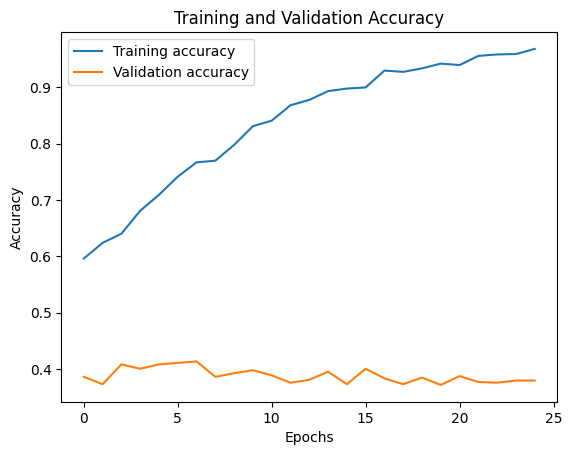

In [54]:

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [55]:
model.save("model.h5")